In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 8.1. Deep Convolutional Neural Networks (AlexNet)

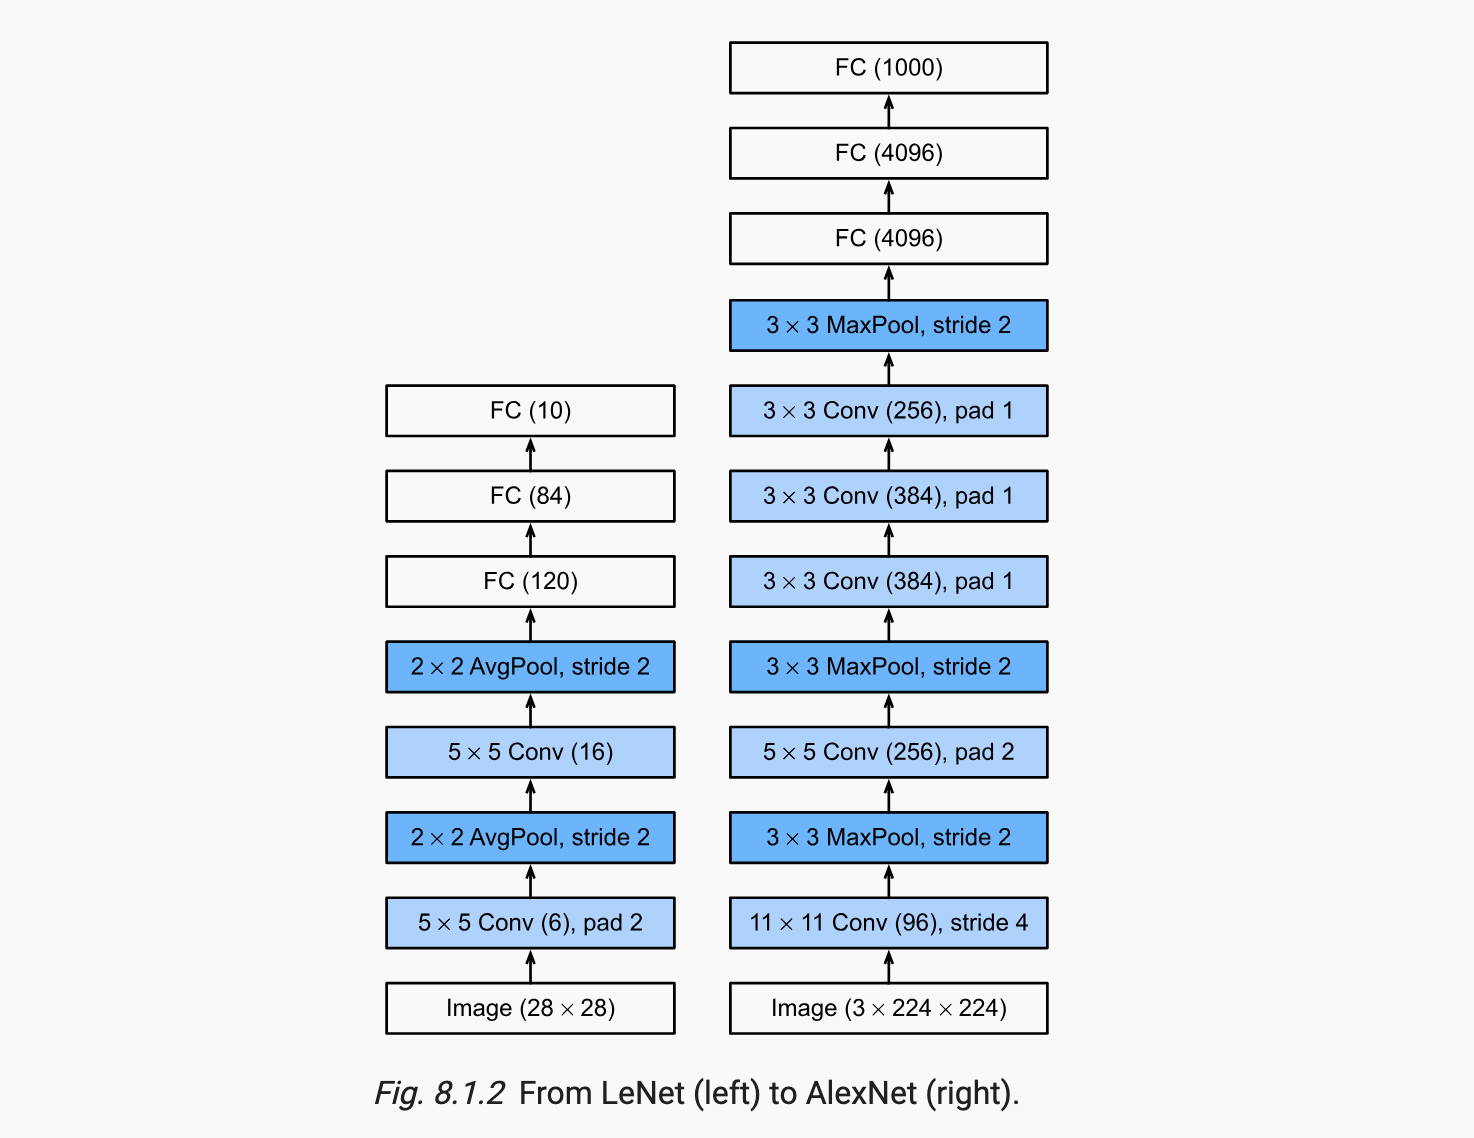

In [2]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Flatten(),
            nn.LazyLinear(4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.LazyLinear(4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes),
        )
        self.net.apply(d2l.init_cnn)

In [3]:
AlexNet().layer_summary((1, 1, 224, 224))

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

- In AlexNet’s first layer, the convolution window shape is 11x11
- The convolution window shape in the second layer is reduced to 5x5, followed by 3x3
- after the first, second, and fifth convolutional layers, the network adds max-pooling layers with a window shape of 3x3 and a stride of 2
- AlexNet has ten times more convolution channels than LeNet
- After the final convolutional layer, there are two huge fully connected layers with 4096 outputs
- AlexNet changed the sigmoid activation function to a simpler ReLU activation function
    - the gradient of the ReLU activation function in the positive interval is always 1. NO GRADIENT VANISHING PROBLEM
- AlexNet controls the model complexity of the fully connected layer by dropout, while LeNet only uses weight decay
- AlexNet added a great deal of image augmentation




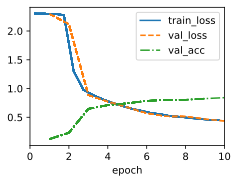

In [4]:
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)

 there is hardly any overfitting: training and validation loss are virtually identical throughout training

# 8.2. Networks Using Blocks (VGG)

a VGG block consists of a sequence of convolutions with 3x3 kernels with padding of 1 (keeping height and width) followed by a 2x2 max-pooling layer with stride of 2 (halving height and width after each block)

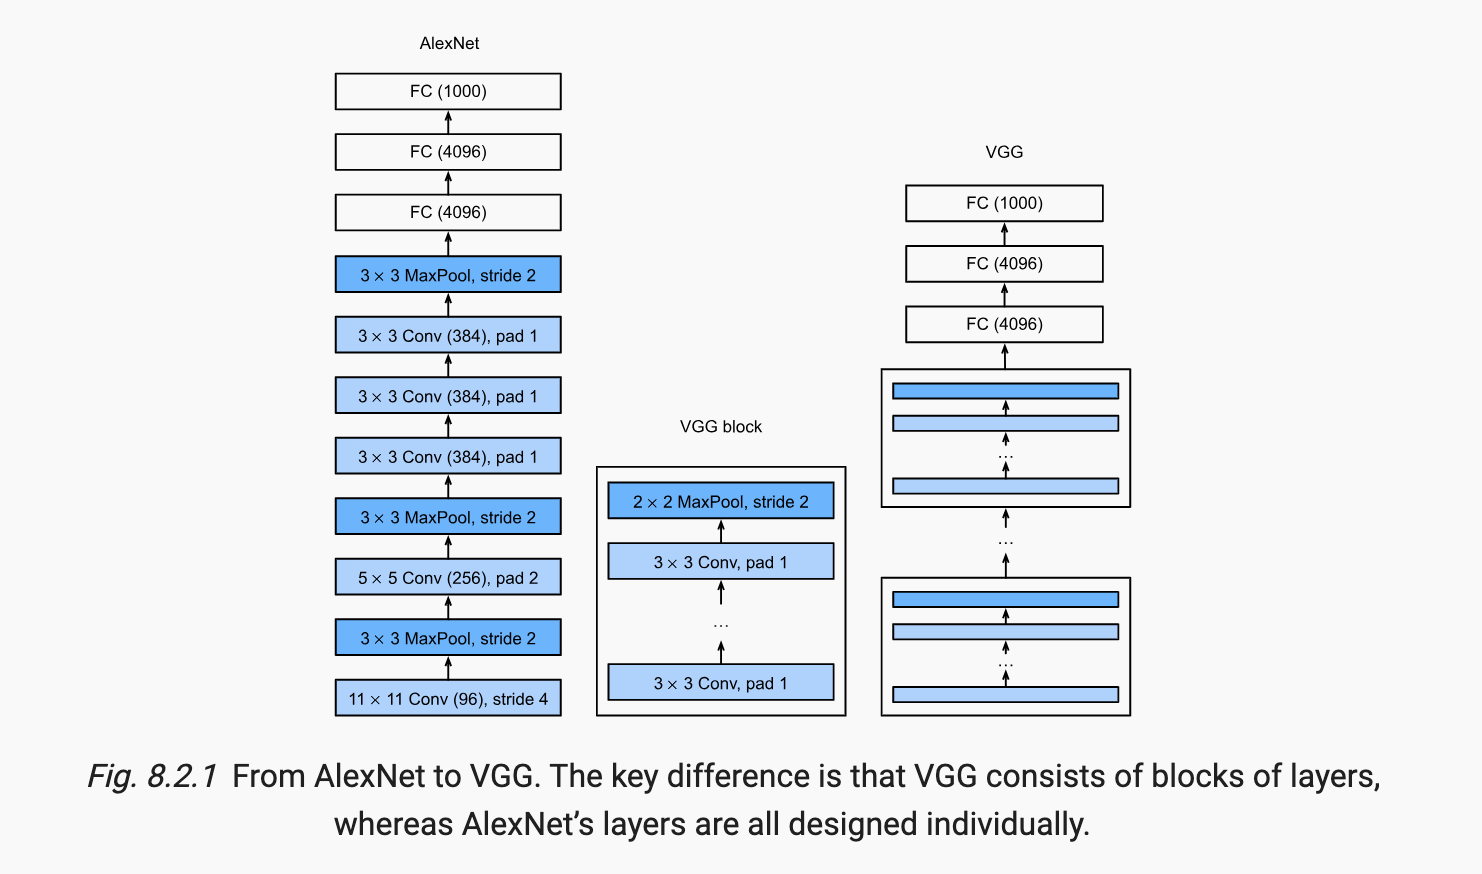

In [5]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [6]:
# VGG-11
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for num_convs, out_channels in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks,
            nn.Flatten(),
            nn.LazyLinear(4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LazyLinear(4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LazyLinear(num_classes)
        )
        self.net.apply(d2l.init_cnn)

In [7]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224)
)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


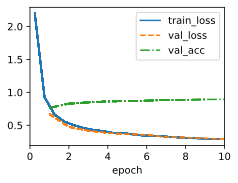

In [8]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# 8.3. Network in Network (NiN)

NiN avoids fully connected layers altogether. Instead, NiN uses a NiN block with a number of output channels equal to the number of label classes, followed by a global average pooling layer, yielding a vector of logits

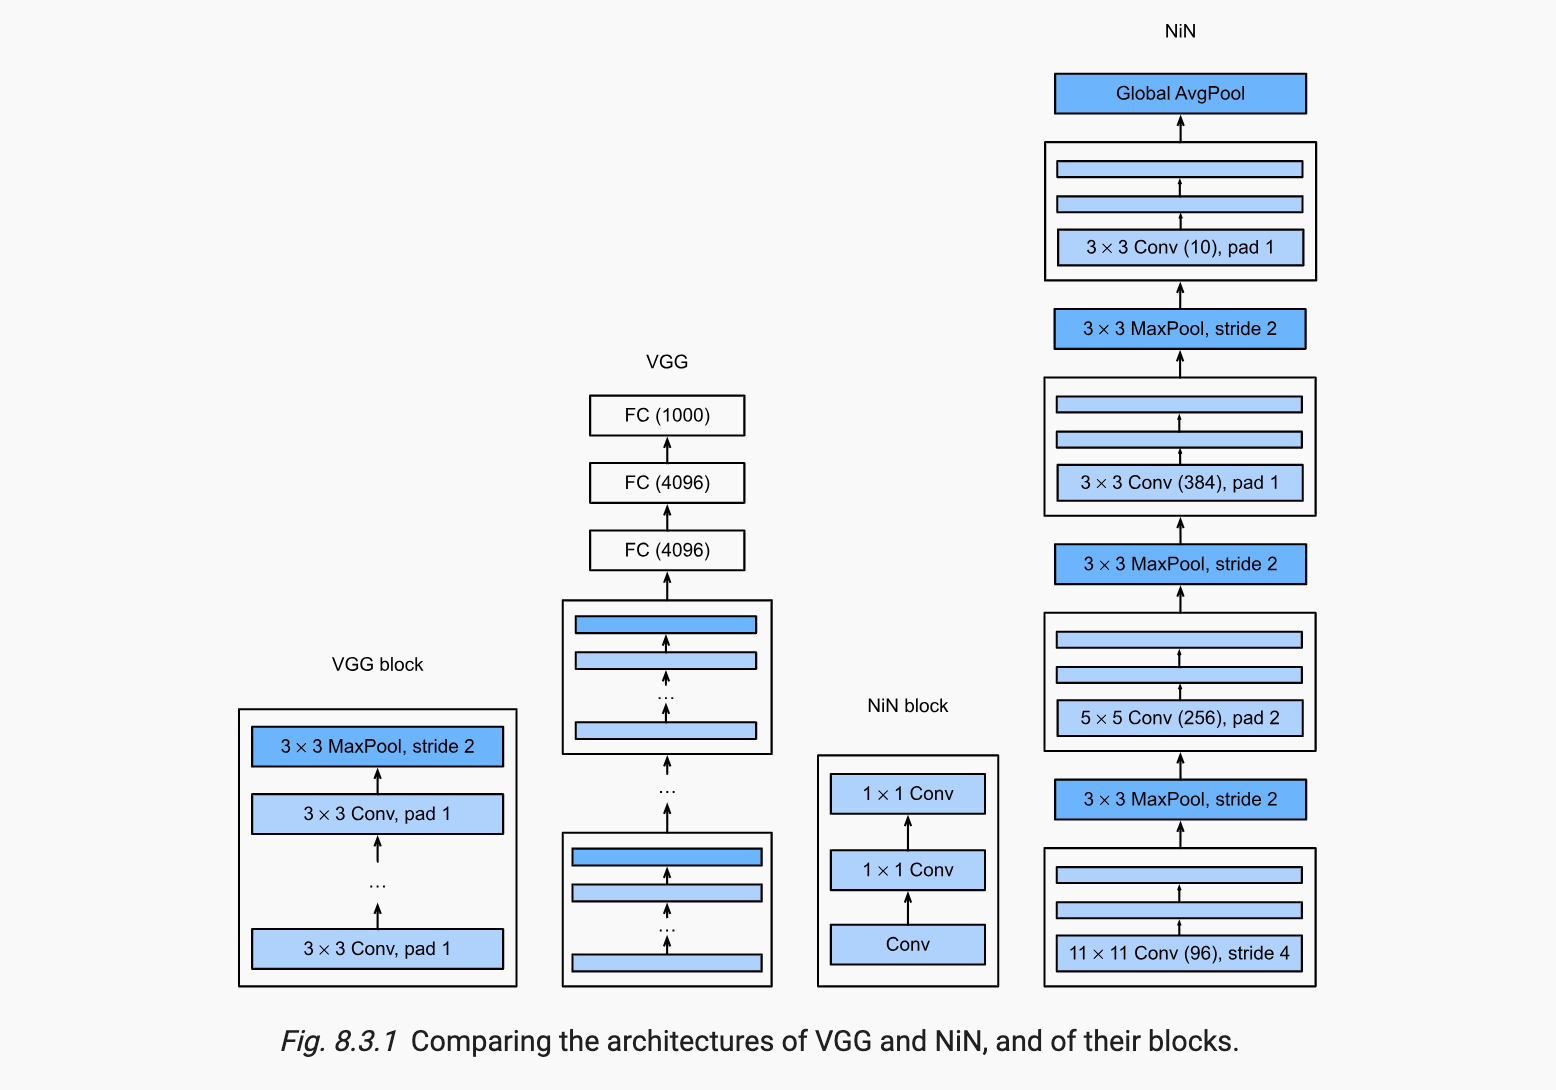

In [9]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1),
        nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1),
        nn.ReLU(),
    )

In [10]:
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )
        self.net.apply(d2l.init_cnn)

In [11]:
NiN().layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


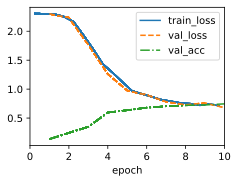

In [12]:
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# 8.4. Multi-Branch Networks (GoogLeNet)

the inception block consists of four parallel branches

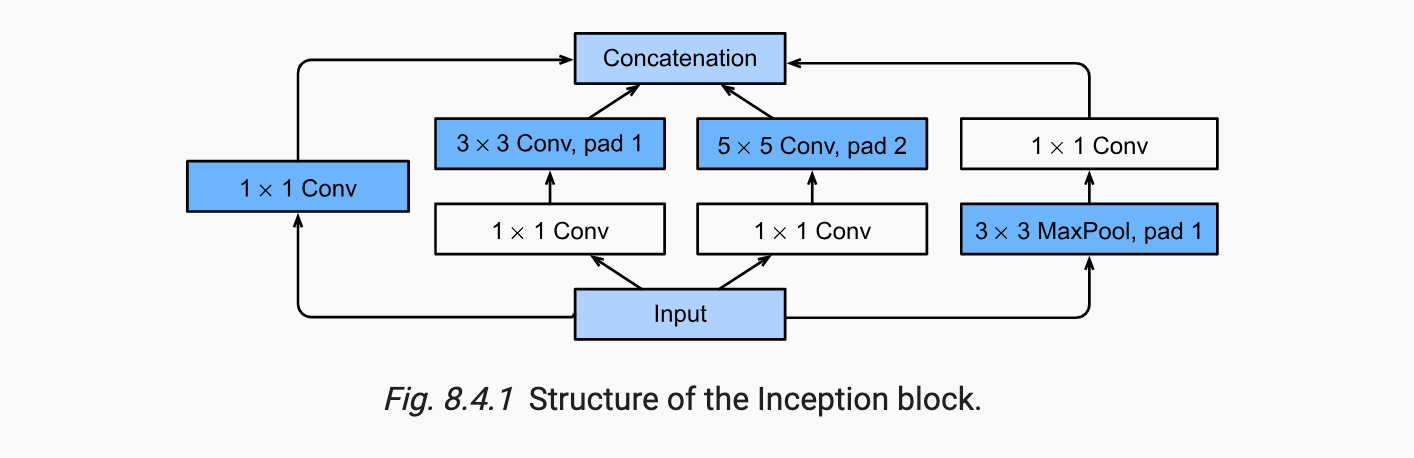

In [13]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

GoogLeNet uses a stack of a total of 9 inception blocks, arranged into three groups with max-pooling in between, and global average pooling in its head to generate its estimates.

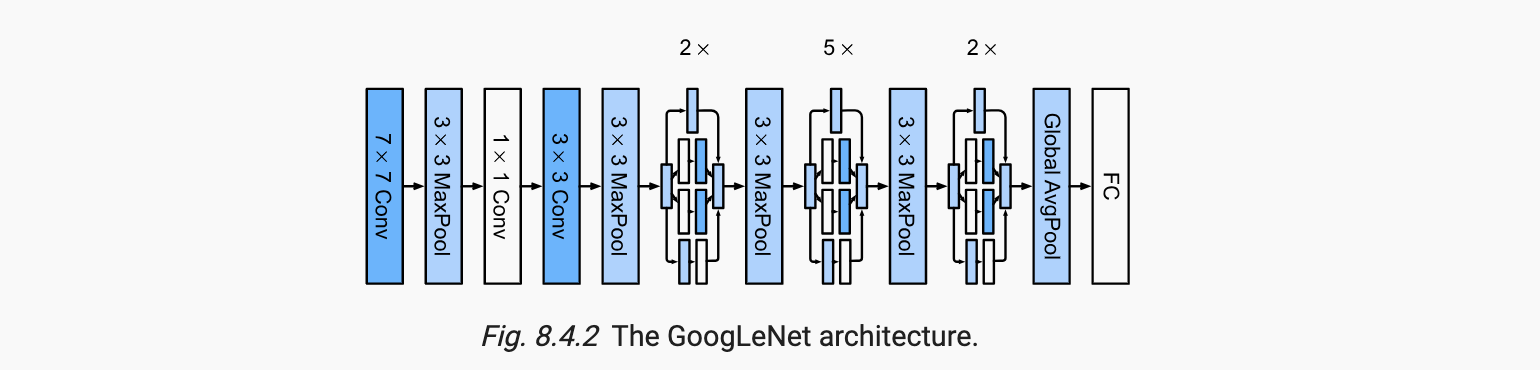

The first module uses a 64-channel 7x7 convolutional layer.

In [14]:
class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

The second module uses two convolutional layers: 
- a 64-channel 1x1 convolutional layer
- 3x3 convolutional layer that triples the number of channels

In [15]:
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1),
        nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    )

The third module connects two complete Inception blocks in series. The number of output channels of the first Inception block is 64+128+32+32=256. This amounts to a ratio of the number of output channels among the four branches of 2:4:1:1. To achieve this, we first reduce the input dimensions by 1/2 and by 1/12 in the second and third branch respectively to arrive at 96=192/2 and 16=192/12 channels respectively.  

The number of output channels of the second Inception block is increased to 128+192+96+64=480, yielding a ratio of 128:192:96:64=4:6:3:2. As before, we need to reduce the number of intermediate dimensions in the second and third channel. A scale of 
1/2 and 1/8 respectively suffices, yielding 128 and 32 channels respectively. This is captured by the arguments of the following Inception block constructors.

In [16]:
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(
        Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    )

The fourth module is more complicated. It connects five Inception blocks in series, and they have 512, 512, 512, 528, and 832 output channels, respectively. The number of channels assigned to these branches is similar to that in the third module: the second branch with the 3x3 convolutional layer outputs the largest number of channels, followed by the first branch with only the 1x1 convolutional layer, the third branch with the 5x5 convolutional layer, and the fourth branch with the 3x3 max-pooling layer. The second and third branches will first reduce the number of channels according to the ratio. These ratios are slightly different in different Inception blocks.

In [17]:
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(
        Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(112, (144, 288), (32, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    )

The fifth module has two Inception blocks with 832 and 1024 output channels. The number of channels assigned to each branch is the same as that in the third and fourth modules, but differs in specific value

In [18]:
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(
        Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
    )

In [19]:
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        self.b1(),
        self.b2(),
        self.b3(),
        self.b4(),
        self.b5(),
        nn.LazyLinear(num_classes),
    )
    self.net.apply(d2l.init_cnn)

In [20]:
model = GoogleNet().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


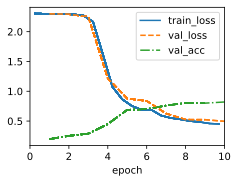

In [21]:
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# 8.5. Batch Normalization

## 8.5.3. Implementation from Scratch

we define the mathematics in a separate function, say batch_norm. We then integrate this functionality into a custom layer, whose code mostly addresses bookkeeping matters

In [ ]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        # used momentum to govern the aggregation over past mean and variance estimates
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

In [23]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X,
            self.gamma,
            self.beta,
            self.moving_mean,
            self.moving_var,
            eps=1e-5,
            momentum=0.1,
        )
        return Y

## 8.5.4. LeNet with Batch Normalization

In [24]:
class BNLeNetScratch(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5),
            BatchNorm(6, num_dims=4),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5),
            BatchNorm(16, num_dims=4),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            BatchNorm(120, num_dims=2),
            nn.Sigmoid(),
            nn.LazyLinear(84),
            BatchNorm(84, num_dims=2),
            nn.Sigmoid(),
            nn.LazyLinear(num_classes),
        )

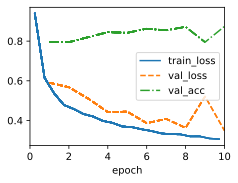

In [25]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNetScratch(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [26]:
model.net[1].gamma.reshape((-1,)), model.net[1].beta.reshape((-1,))

(tensor([1.8664, 2.0111, 1.7006, 1.8386, 1.7251, 2.0085], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([ 0.2849, -1.4353,  0.5459,  1.4382, -0.9262, -0.1078], device='cuda:0',
        grad_fn=<ViewBackward0>))

## 8.5.5. Concise Implementation

In [27]:
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5),
            nn.LazyBatchNorm2d(),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5),
            nn.LazyBatchNorm2d(),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.LazyBatchNorm1d(),
            nn.Sigmoid(),
            nn.LazyLinear(84),
            nn.LazyBatchNorm1d(),
            nn.Sigmoid(),
            nn.LazyLinear(num_classes),
        )

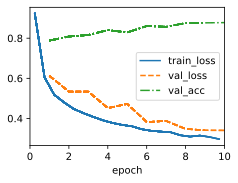

In [28]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# 8.6. Residual Networks (ResNet) and ResNeXt

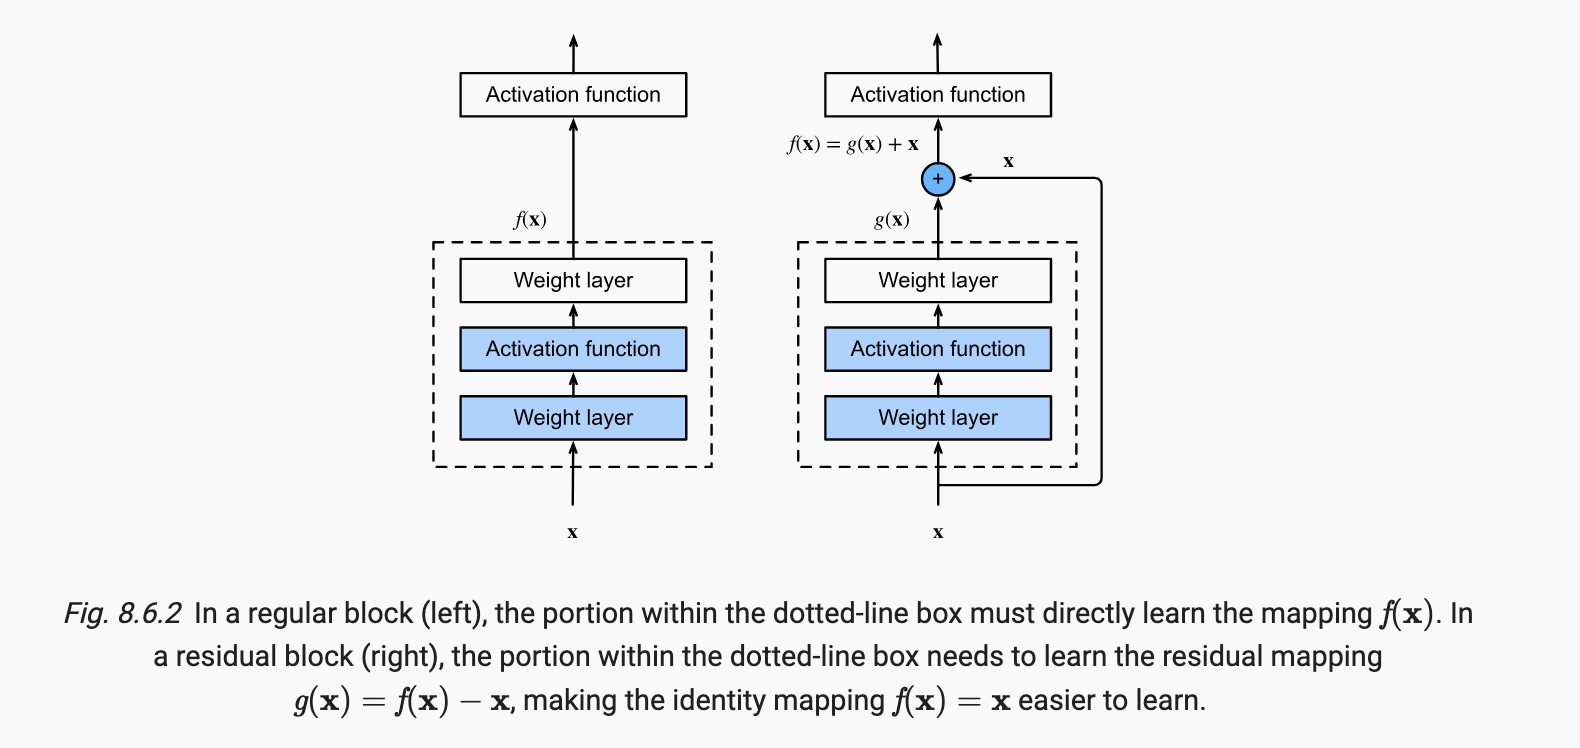
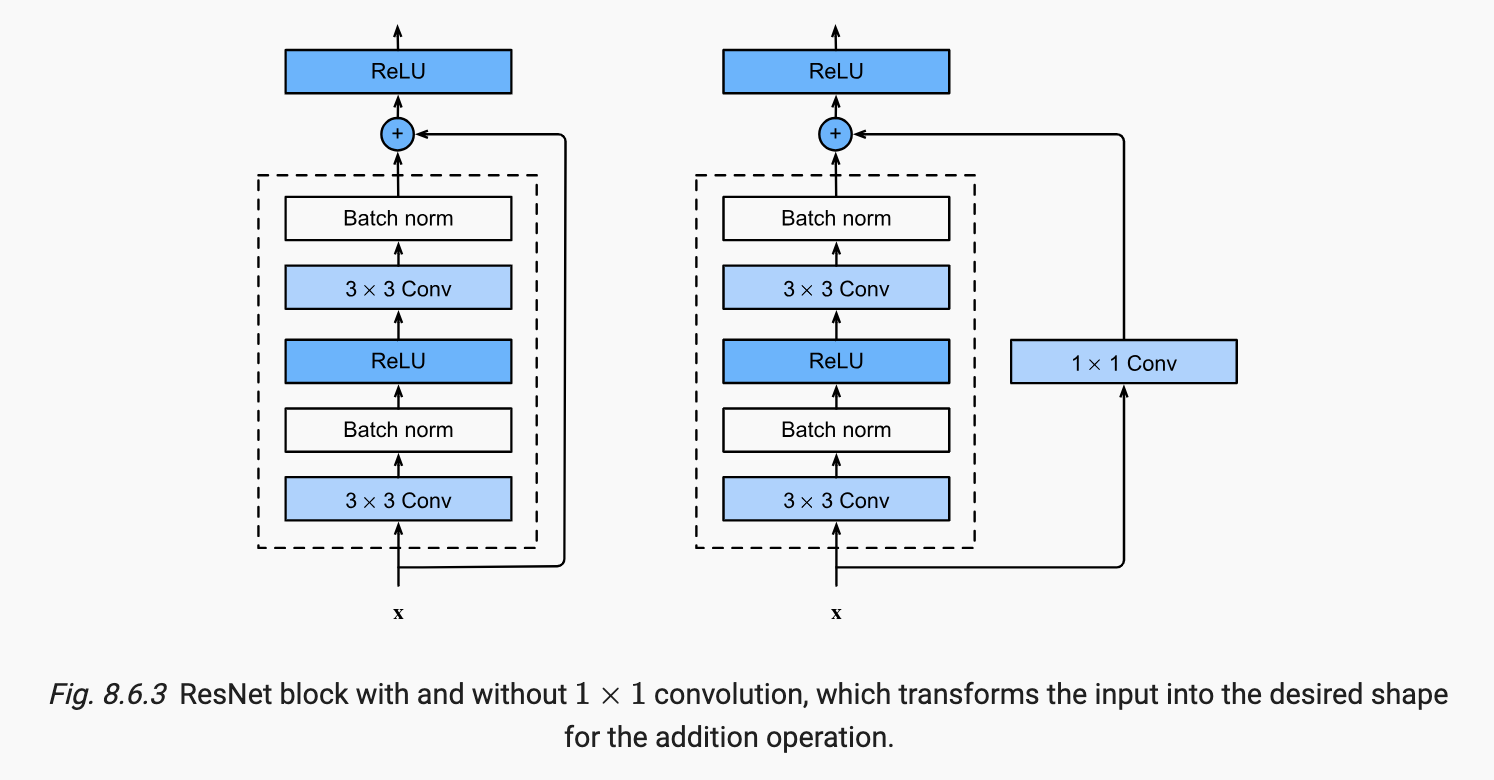

In [29]:
class Residual(nn.Module):  # @save
    """The Residual block of ResNet models."""

    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(
            num_channels, kernel_size=3, padding=1, stride=strides
        )
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [30]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [ ]:
# halve the output height and width while increasing the number of output channels
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [32]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

In [33]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [34]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f"b{i+2}", self.block(*b, first_block=(i == 0)))
    self.net.add_module(
        "last",
        nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.LazyLinear(num_classes)
        ),
    )
    self.net.apply(d2l.init_cnn)

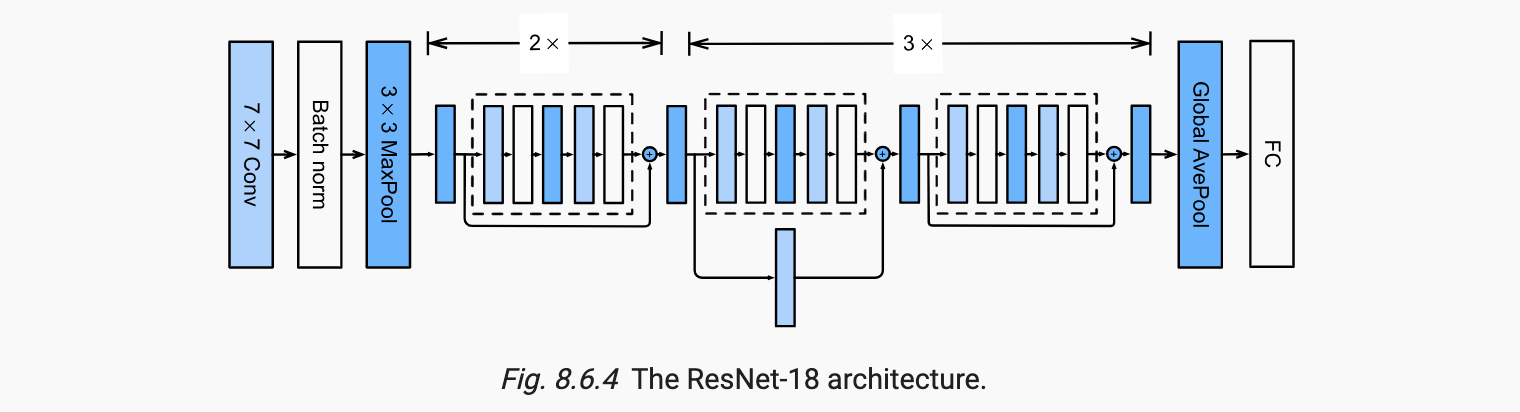

In [35]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)), lr, num_classes)


ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


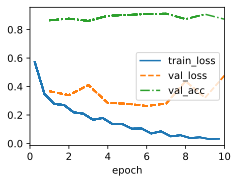

In [36]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

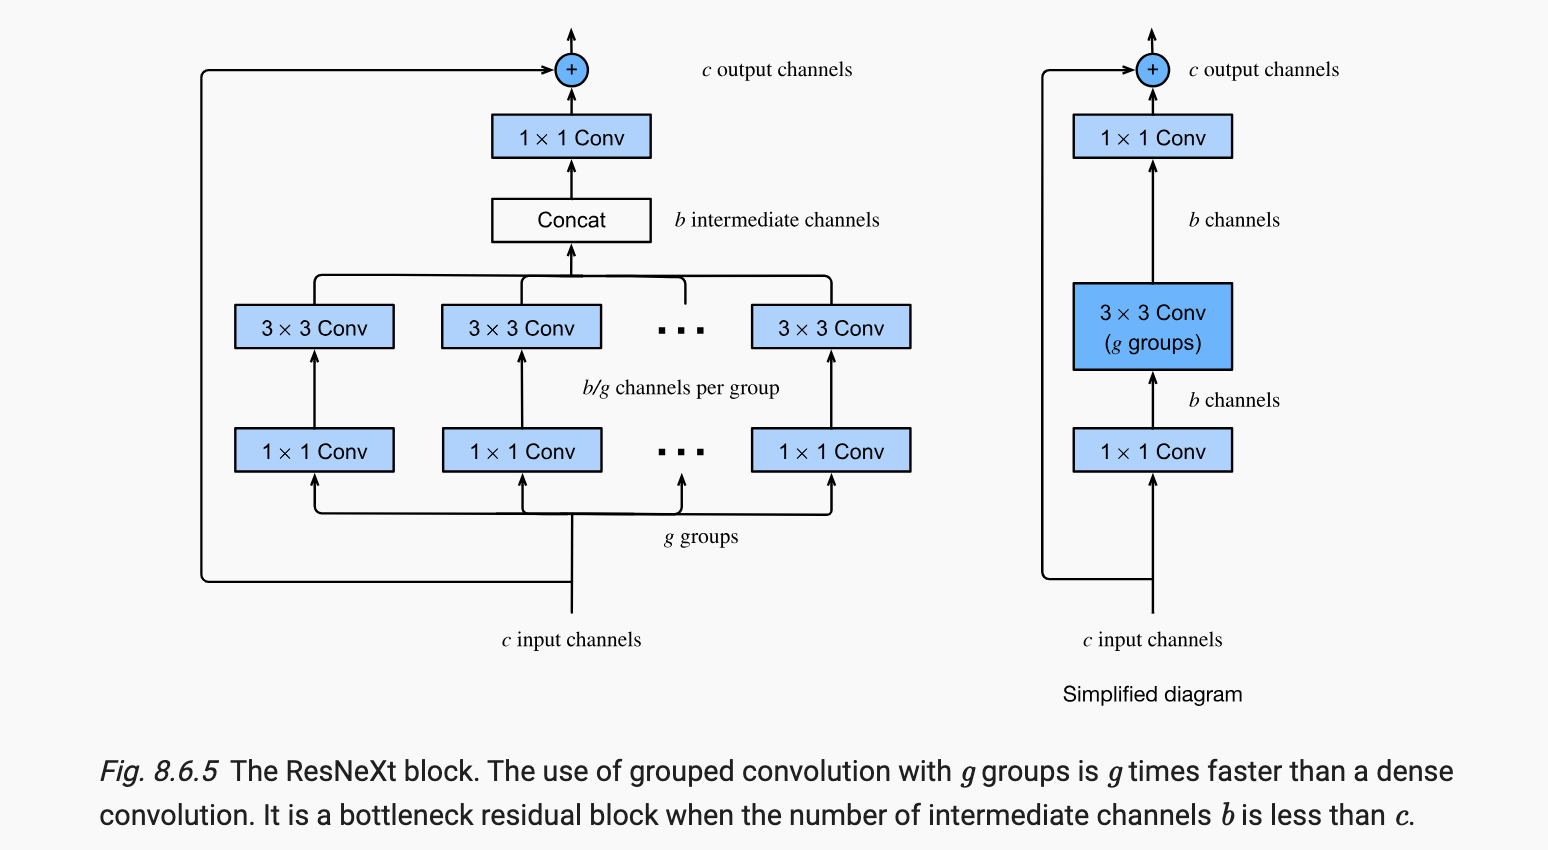

In [37]:
class ResNeXtBlock(nn.Module):  # @save
    """The ResNeXt block."""

    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False, strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(
            bot_channels,
            kernel_size=3,
            stride=strides,
            padding=1,
            groups=bot_channels // groups,
        )
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

In [38]:
blk = ResNeXtBlock(32, 16, 1)
X = torch.randn(4, 32, 96, 96)
blk(X).shape

torch.Size([4, 32, 96, 96])

# 8.7. Densely Connected Networks (DenseNet)

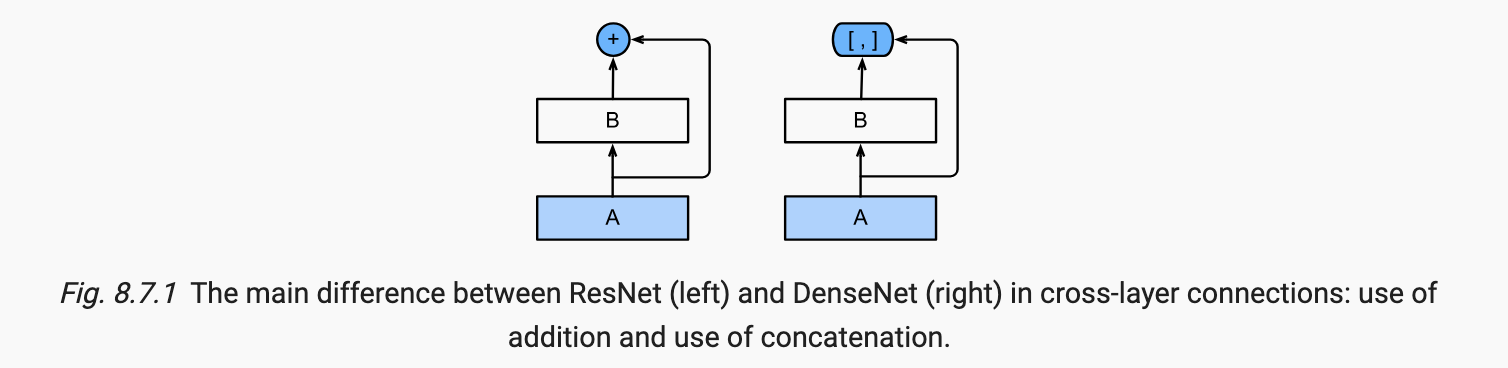
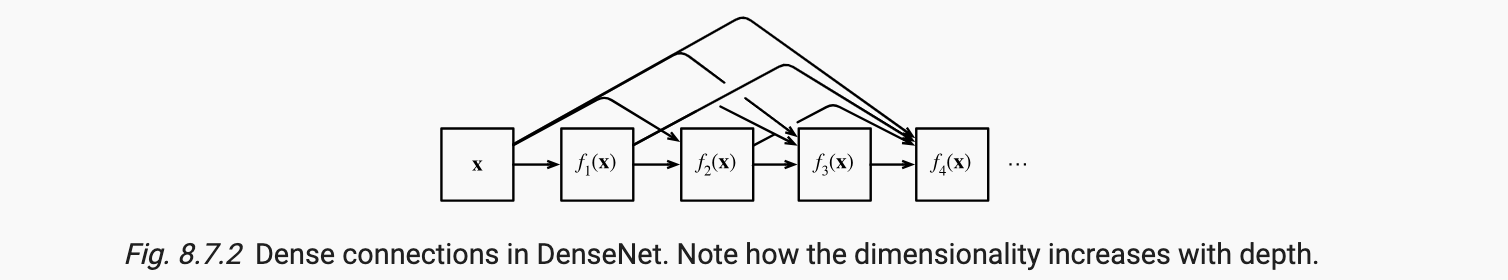

## 8.7.2. Dense Blocks

In [48]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(),
        nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1),
    )

In [40]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

In [41]:
blk = DenseBlock(2, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

## 8.7.3. Transition Layers

A transition layer is used to control the complexity of the model. It reduces the number of channels by using a 1x1 convolution. Moreover, it halves the height and width via average pooling with a stride of 2.

In [42]:
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(),
        nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2),
    )

In [44]:
blk = transition_block(10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## 8.7.4. DenseNet Model

In [45]:
class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

In [46]:
@d2l.add_to_class(DenseNet)
def __init__(
    self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4), lr=0.1, num_classes=10
):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f"dense_blk{i+1}", DenseBlock(num_convs, growth_rate))
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f"tran_blk{i+1}", transition_block(num_channels))
    self.net.add_module(
        "last",
        nn.Sequential(
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.LazyLinear(num_classes),
        ),
    )
    self.net.apply(d2l.init_cnn)

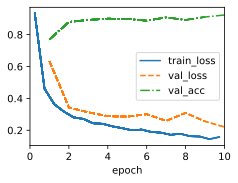

In [47]:
model = DenseNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

# 8.8. Designing Convolution Network Architectures

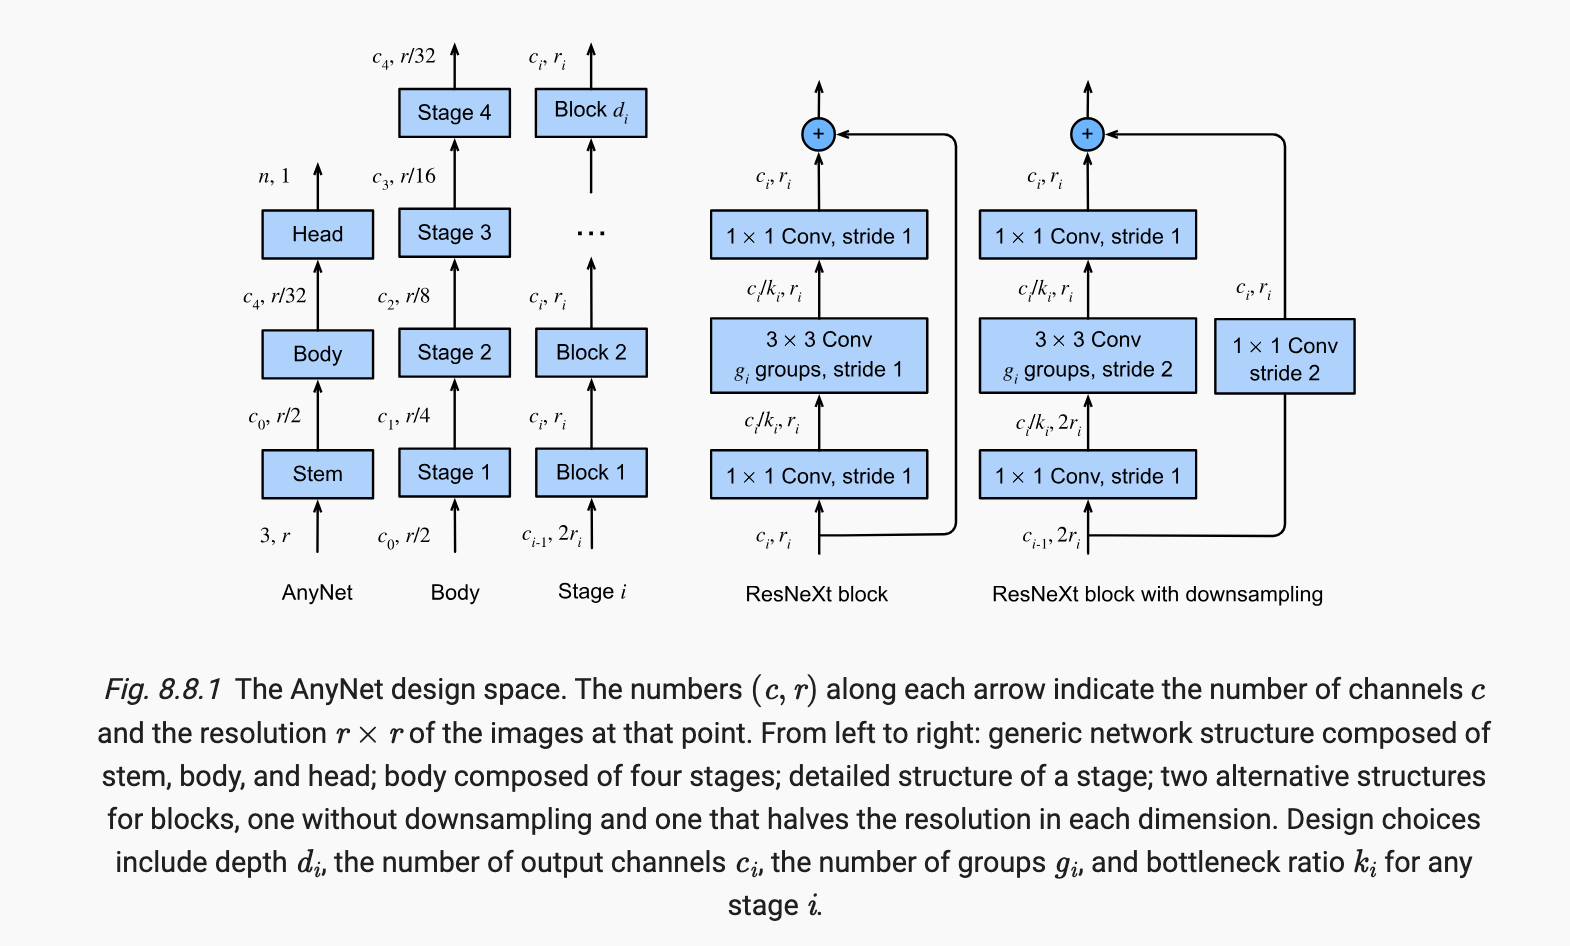

In [49]:
class AnyNet(d2l.Classifier):
    def stem(self, num_channels):
        return nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
        )

In [50]:
@d2l.add_to_class(AnyNet)
def stage(self, depth, num_channels, groups, bot_mul):
    blk = []
    for i in range(depth):
        if i == 0:
            blk.append(
                d2l.ResNeXtBlock(
                    num_channels, groups, bot_mul, use_1x1conv=True, strides=2
                )
            )
        else:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul))
    return nn.Sequential(*blk)

In [51]:
@d2l.add_to_class(AnyNet)
def __init__(self, arch, stem_channels, lr=0.1, num_classes=10):
    super(AnyNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.stem(stem_channels))
    for i, s in enumerate(arch):
        self.net.add_module(f"stage{i+1}", self.stage(*s))
    self.net.add_module(
        "head",
        nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.LazyLinear(num_classes)
        ),
    )
    self.net.apply(d2l.init_cnn)

In [52]:
class RegNetX32(AnyNet):
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 1
        depths, channels = (4, 6), (32, 80)
        super().__init__(
            (
                (depths[0], channels[0], groups, bot_mul),
                (depths[1], channels[1], groups, bot_mul),
            ),
            stem_channels,
            lr,
            num_classes,
        )

In [53]:
RegNetX32().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 32, 48, 48])
Sequential output shape:	 torch.Size([1, 32, 24, 24])
Sequential output shape:	 torch.Size([1, 80, 12, 12])
Sequential output shape:	 torch.Size([1, 10])


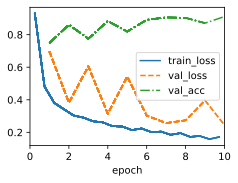

In [54]:
model = RegNetX32(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)